# Different subgrid parameterizations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from L96 import *
from EnKF import *
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,7)
sns.set_style('dark')
sns.set_context('talk')

In [3]:
h = xr.open_dataset('./L96TwoLevel_ref.nc'); h

<xarray.Dataset>
Dimensions:  (time: 200001, x: 36, y: 360)
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 200.0 200.0 200.0 200.0
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Data variables:
    X        (time, x) float64 ...
    B        (time, x) float64 ...
    Y_mean   (time, x) float64 ...
    Y2_mean  (time, x) float64 ...

In [4]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)
features.shape, targets.shape

((7200036,), (7200036,))

In [5]:
l96 = L96TwoLevel(noYhist=True)
l96.iterate(20)
init=l96.state
initX=l96.X
initY=l96.Y

In [6]:
means = np.load('./L96TwoLevel_means.npy')
variances = np.load('./L96TwoLevel_variances.npy')

In [7]:
def climate_error(l):
    return np.sqrt((((means - l.mean_stats(0))/np.sqrt(variances))**2)).mean()

## Simple polynomials

### Linear regression

In [86]:
p = np.polyfit(features, targets, 1); p

array([-0.30723981, -0.21149115])

In [87]:
class PolyParam():
    def __init__(self, p):
        self.p = p
    def __call__(self, x):
        return np.polyval(self.p, x)

In [88]:
param = PolyParam(p)

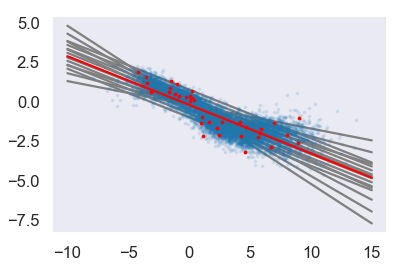

In [89]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, param(tmp), c='r')
for i in np.arange(-0.5, -0.1, 0.05):
    plt.plot(tmp, PolyParam([i, p[-1]])(tmp), c='gray', zorder=0.1)
for i in np.arange(-1, 1, 0.25):
    plt.plot(tmp, PolyParam([p[0], i])(tmp), c='gray', zorder=0.1)
plt.scatter(features[-36:], targets[-36:], s=5, alpha=1, c='r')

In [36]:
l96_param = L96TwoLevel(noYhist=True, parameterization=param)

In [37]:
l96_param.iterate(20)

In [38]:
climate_error(l96_param)

0.08420750555660585

In [159]:
err_p1 = []
for p1 in tqdm(np.arange(-1, 1, 0.25)):
    l96_tmp =  L96TwoLevel(noYhist=True, parameterization=PolyParam([p1, p[1]]), noprog=True)
    l96_tmp.iterate(20)
    err_p1.append(climate_error(l96_tmp))
    
err_p2 = []
for p2 in tqdm(np.arange(-1, 1, 0.25)):
    l96_tmp = L96TwoLevel(noYhist=True, parameterization=PolyParam([p[0], p2]), noprog=True)
    l96_tmp.iterate(20)
    err_p2.append(climate_error(l96_tmp))

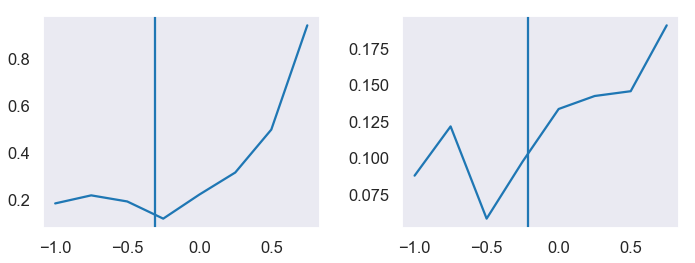

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(np.arange(-1, 1, 0.25), err_p1)
axs[0].axvline(p[0])
axs[1].plot(np.arange(-1, 1, 0.25), err_p2)
axs[1].axvline(p[1])
plt.tight_layout()

## Higher order polynomials

In [55]:
err = []
for deg in range(1, 6):
    p = np.polyfit(features, targets, deg)
    param = PolyParam(p)
    l96_tmp = L96TwoLevel(noYhist=True, parameterization=param, noprog=True)
    l96_tmp.iterate(20)
    err.append(climate_error(l96_tmp))

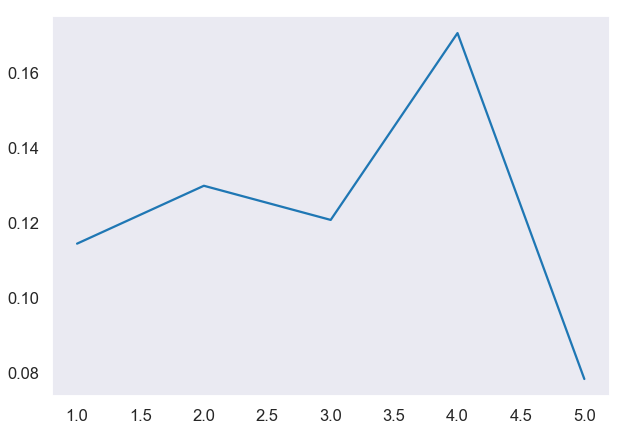

In [56]:
plt.plot(range(1, 6), err)

## Can we learn a simple linear regression with the EnKF?

### What should the initial conditions be?

In [70]:
n = features.shape[0]; n

7200036

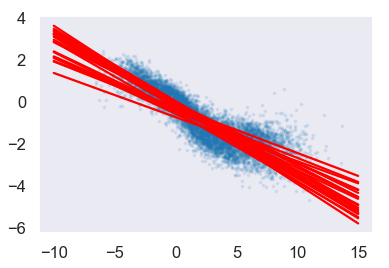

In [71]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
ps  =[]
for i in range(20):
    idxs = np.random.randint(0, n, 10)
    p = np.polyfit(features[idxs], targets[idxs], 1)
    ps.append(p)
    #plt.scatter(features[idxs], targets[idxs], s=5, alpha=1, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p, tmp), c='r')

In [72]:
ps = np.array(ps)

In [73]:
ps.mean(0), ps.var(0)

(array([-0.30084021, -0.28517852]), array([0.00230562, 0.04236086]))

In [74]:
def set_state(l, x_a):
    l.parameterization.p = x_a

In [75]:
def H(l):
    return l.mean_stats(0)

In [76]:
r = 0.5

In [77]:
def init_p(l, prior, sigma):
    l.parameterization.p = prior + np.random.normal(0, np.sqrt(sigma))

In [78]:
class L96TwoLevelParam(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @property
    def parameters(self):
        return self.parameterization.p

In [79]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p)), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=10, 
    mp=50, 
    get_state=lambda l: l.parameterization.p,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

In [80]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [81]:
enkf.initialize_parameters(init_p, priors=ps.mean(0)*2, sigmas=ps.var(0)*10)

In [82]:
enkf.iterate(5)

In [83]:
enkf.climate_error

[0.38357721320765215,
 0.2806891406452665,
 0.26429500588698085,
 0.27512400950455007,
 0.27056603611359115]

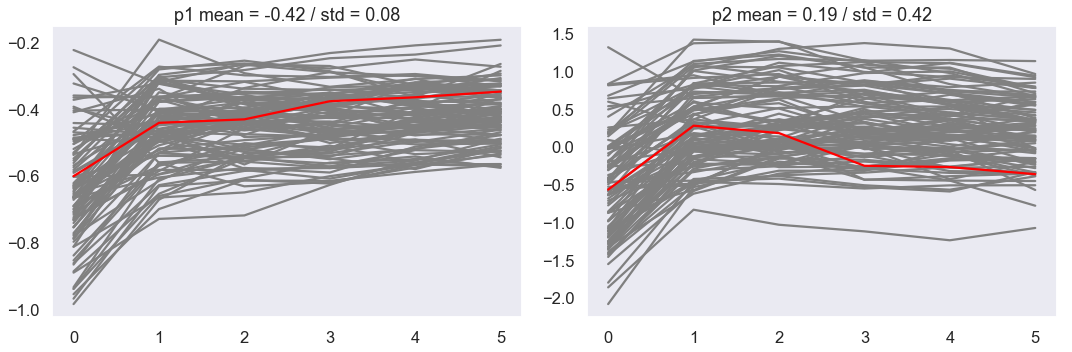

In [84]:
plot_params(enkf, names=['p1', 'p2'])

In [ ]:
p

## higher-order polynomial learning

In [57]:
p = np.polyfit(features, targets, 2); p

array([ 0.01816547, -0.40314503, -0.31091095])

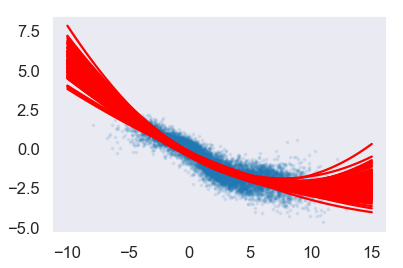

In [58]:
ps  =[]
for i in range(100):
    idxs = np.random.randint(0, n, 100)
    p = np.polyfit(features[idxs], targets[idxs], 2)
    ps.append(p)
    #plt.scatter(features[idxs], targets[idxs], s=5, alpha=1, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p, tmp), c='r')
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)

In [59]:
ps = np.array(ps); ps.shape

(100, 3)

In [60]:
class InitP():
    def __init__(self, p, ps):
        self.p, self.ps = p, ps
        self.i = 0
    def __call__(self, l, prior, sigma):
        if np.mean(sigma) == 0: 
            l.parameterization.p = self.p
        else:
            l.parameterization.p = self.ps[self.i]
            self.i +=1

In [61]:
init_p = InitP(p, ps)

In [62]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p)), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=5, 
    mp=50, 
    get_state=lambda l: l.parameterization.p,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

In [63]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [64]:
enkf.initialize_parameters(init_p, priors=ps.mean(0), sigmas=ps.var(0))

In [65]:
enkf.iterate(3)

In [66]:
enkf.climate_error

[0.41527602343447007, 0.4123303359050835, 0.4285318740076934]

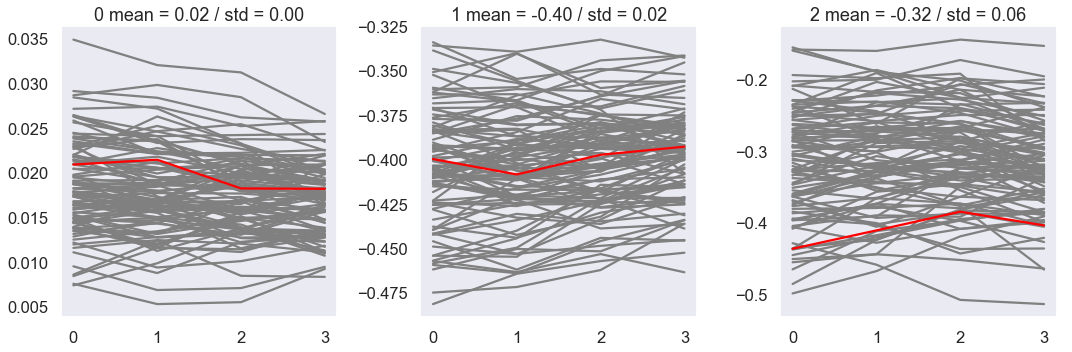

In [68]:
plot_params(enkf, names=['0', '1', '2'])

In [69]:
p

array([ 0.02088826, -0.399799  , -0.43639627])